In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from IPython.display import display
import GPy

In [3]:
np.random.seed(123) # Initialize random number generator

## Introduction
A Gaussian process is fully specified by a mean function $m(x)$ and a covariance function $k(x,x')$:

\begin{equation}
f(x) \sim \mathcal{GP}\big(m(x),k(x,x')\big)
\end{equation}

Compare this to common parametric models:
 - Logistic regression: $y = \sigma(\mathbf{\theta}^T\mathbf{x})$
 - Bayesian linear regression: $y \sim \mathcal{N}(\mathbf{\theta}^T\mathbf{x},\sigma^2)$
 
These models are parametric because they rely on a set of parameters $\theta$ to model data. On the other hand, a Gaussian process uses only a mean and covariance function. Without loss of generality, the mean function is usually set to zero, $m(x) = 0$. Whereas, the covariance function or kernel simply defines how any two data points should covary.

## Distribution over functions
Because of its non-parametric form, the prior of a Gaussian process is a *distribution over functions*. This property is something worth understanding because it is the reason for the expressiveness and generalisation ability of GPs.

First, we can define a GP prior by selecting a mean function, which we will set to zero, and a covariance function. In this case, we will use the squared exponential kernel:

\begin{equation}
k(x,x') = \sigma^2 \text{exp}\Big(\frac{-(x-x')^2}{2l^2}\Big)
\end{equation}

We will consider two hyperparameters of the kernel:
 - The scale factor $\sigma^2$ determines the average distance of the function away from its mean.
 - The length scale $l$ determines the radius of influence that every point $x$ has on its neighbouring points $x'$.

Normally, training a GP requires us to tune the kernel hyperparameters by optimising a likelihood measure. <br>
But for now, let's define our kernel with $\sigma^2 = 0.5^2$ and $l = 1$.

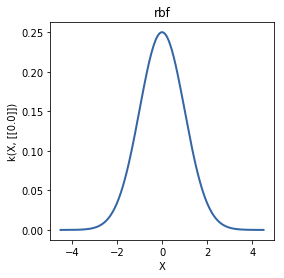

In [4]:
k = GPy.kern.RBF(1, variance=0.5**2, lengthscale=1)
figure, ax = plt.subplots(1,1, figsize=(4,4))
k.plot(ax=ax, x=0)
ax.set_title(k.name.replace('_', ' '))
plt.show()

## Sampling functions from a GP prior
With a prior in place, we have effectively specified a distribution over functions. In other words, our choice of kernel determines that some functions are more likely than others. For instance:
 - Using the squared exponential kernel, we expect the function to be smooth.
 - With $l = 1$, we expect strong covariance between points which are within one unit length of each other.
 - With $\sigma = 0.5$, we expect the function to not stray too far from the predicted mean.
 
We can visualise what this might look like by drawing samples from our distribution. In particular, we will randomly sample function values at a finite set of $x$ values and plot them. 

*Feel free to skip past the code if you are not interested in the details.*

## Initialisation and helper functions 

In [5]:
# Graph parameters
lb = -5
ub = 5
y_min = -2.5
y_max = -1 * y_min

In [6]:
def initFirstPoint():
    firstPoint = True
    x_new = 0
    mu_new = 0 
    s_new = 0.5
    return firstPoint, x_new, mu_new, s_new

In [7]:
def initData():
    X_train = np.array([])
    y_train = np.array([])
    
    n_test = 100
    X_test = np.linspace(lb,ub,n_test)
    mu_test = np.zeros((n_test,1))
    s_test = 0.5 * np.ones((n_test,1)) 
    return X_train, y_train, X_test.reshape(-1,1), mu_test, s_test

In [8]:
def initRegressionModel(X_train, y_train):
    """Change here for choice of kernel"""
    k = GPy.kern.RBF(1, variance=0.5**2, lengthscale=1)
    #k = GPy.kern.PeriodicExponential(1)
    #k = GPy.kern.Matern52(1)
    
    m = GPy.models.GPRegression(X_train, y_train, k, noise_var=0)
    return m

In [9]:
def addTrainingPoint(X_train, y_train, x_new, y_new):    
    X_train = np.append(X_train,x_new)
    y_train = np.append(y_train,y_new)
    return X_train.reshape(-1,1), y_train.reshape(-1,1)

In [10]:
def addConfidenceBounds(ax, x, mu, s):
    ax.fill_between(np.squeeze(x), np.squeeze(mu-2*s), np.squeeze(mu+2*s), facecolor='grey', alpha=0.2)

def removeConfidenceBounds(ax):
    for coll in (ax.collections): ax.collections.remove(coll)

## Animation: sequential sampling

In [11]:
# Code to create animation
import matplotlib.animation
plt.rcParams["animation.html"] = "html5"

# Reset data
firstPoint, x_new, mu_new, s_new = initFirstPoint()
X_train, y_train, X_test, mu_test, s_test = initData()

# Initialise plot
fig,ax = plt.subplots(1,1, figsize=(8, 6), dpi=100)
ax.set_xlim(lb,ub)
ax.set_ylim(y_min,y_max)
plt.ylabel('y'); plt.xlabel('x');

line_post, = ax.plot(X_test, mu_test, label="f_pred")
line_next = ax.axvline(x_new, color='r', linestyle="dashed", label="next sample location")
pts_train, = ax.plot(X_train, y_train, 'rx', label="training points")
addConfidenceBounds(ax, X_test, mu_test, s_test)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fancybox=True, shadow=True)

def addAndRetrain(b=None):
    global X_train, y_train, mu_test, s_test, x_new, mu_new, s_new, firstPoint, m
    # Add new training point based on x_new
    y_new = np.random.normal(mu_new, s_new)
    X_train,y_train = addTrainingPoint(X_train, y_train, x_new, y_new) 
    if firstPoint:
        firstPoint = False
        m = initRegressionModel(X_train, y_train)   
    
    # Update training data
    m.set_XY(X_train,y_train)
    
    # Generate predictions
    mu_test, s2_test = m.predict(X_test)
    s_test = np.sqrt(s2_test)

    # Sample next training point
    x_new = np.random.uniform(low=lb, high=ub, size=1) 
    mu_new, s2_new = m.predict(x_new.reshape(-1,1))
    s_new = np.sqrt(s2_new)
    
    updatePlot()
    
def updatePlot():
    line_post.set_data(X_test, mu_test)
    pts_train.set_data(X_train, y_train)
    line_next.set_xdata(x_new)
    removeConfidenceBounds(ax)
    addConfidenceBounds(ax, X_test, mu_test, s_test)    
    fig.canvas.draw()

def animate(i):
    if i == 0: pass
    else: addAndRetrain()

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=10, interval=1000)
ani

## Remarks
Here are a couple of things worth noticing:
 - The shape of our function is solely affected by two things: the covariance function and observations.
 - At the start, there are no observations available. Hence, the distribution over functions is only restricted by our prior of mean zero and scale factor 0.25.
 - The prior is sequentially updated as we begin to make observations.
 - In particular, an observation influences neighbouring points because we expect data to covary. For instance, the region sandwiched between two observations has very little uncertainty, because we have effectively pinned down its value.
 - Notice how the function reverts to the prior in the absence of data.

## Conclusion
In this notebook, we have fixed the kernel hyperparameters to some pre-defined values. However, in practice, these parameters are often tuned by maximising the log marginal likelihood of the training data.

To see how the parameters affect the distribution over functions, you can experiment with different values of the length scale $l$ and scale factor $\sigma^2$. 

<h2><center>Key takeaway: a Gaussian Process is a distribution over functions!</center></h2>
